In [12]:
import numpy as np
import matplotlib.pyplot as plt

from aeons.tools import pickle_in
samples_g_1, samples_c_1, samples_w_1 = pickle_in("../test_samples/samples_1.pickle")
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("error", category=RuntimeWarning)

from aeons.lm_partial import analytic_lm_params, X_end_formula
from aeons.covariance import X_mu, X_Sigmainv, logX_mu, points_at_iteration
from aeons.true_distribution import generate_Xs, nk_dead, nk_dead_live, nk_live
from aeons.likelihoods import likelihood, linear_like, quad_like, log_like, simple_like, middle_like, full_like
linear, quad, log = linear_like(), quad_like(), log_like()
simple, middle, full = simple_like(), middle_like(), full_like()
from aeons.models import LS, CG

$$\int_0^{X_i} \exp\left(-\frac{X^{2/d}}{2\sigma^2}\right)\ dX = \frac{d}{2} \cdot 2^{d/2} \sigma^{d} \gamma\left(d/2,\ X_i^{2/d}/2\sigma^2\right)$$

#### **Functions**

In [32]:
from aeons.toy_samples import gaussian_samples
from scipy.special import gammainc, gamma, logsumexp, loggamma
def logZlive(Xi, theta):
    logLmax, d, sigma = theta
    prefactor = logLmax + d/2*np.log(2) + d*np.log(sigma) + np.log(d/2)
    loggammainc = np.log( gammainc( d/2 , Xi**(2/d)/(2*sigma**2) ) * gamma(d/2) )
    return prefactor + loggammainc

def dlogX_calc(logX):
    # Returns dlogX from outside in
    logXp = np.roll(logX, 1)
    logXp[0] = 0
    logXm = np.roll(logX, -1)
    logXm[-1] = -np.inf
    dlogX = np.log(1 - np.exp(logXm-logXp)) + logXp - np.log(2)
    return dlogX

def logZ_trapz(logL, logX):
    dlogX = dlogX_calc(logX)
    return logsumexp(dlogX + logL)

def logXf_formula(logZlive, logZdead, logLmax):
    return logsumexp(logZlive, logZdead - logLmax)

def logXf_formula_gaussian(theta, epsilon=1e-3):
    _, d, sigma = theta
    return d/2*np.log(2) + d * np.log(sigma) + loggamma(1 + d/2) + np.log(epsilon)

In [35]:
def plot_like(loglike, theta, logX_min=-40, samples=None):
    logXarray = np.linspace(logX_min, 0, 1000)
    Xarray = np.exp(logXarray)
    Larray = np.exp(loglike(Xarray, theta))
    fig, ax1 = plt.subplots(figsize=(6.7, 3))
    ax2 = plt.twinx(ax1)
    ax1.plot(logXarray, Larray, lw=1, color='black')
    ax2.fill(logXarray, Larray*Xarray, alpha=0.2)
    if samples:
        Xsamples, ndead = samples
        ax2.axvline(x=Xsamples[ndead], lw=.5, ls='--')
        ax2.axvline(x=Xsamples[-1], lw=.5, ls='--')

def minimise_bandwidth(logL, X_mean, ndead, alphas, x0):
    theta_best = None
    logZi = -np.inf
    for alpha in alphas:
        startf = int(ndead * (1 - alpha))
        logLf = logL[startf:]
        X_meanf = X_mean[startf:]
        ls = LS(logL, full, X_mean)
        theta = analytic_lm_params(logLf, X_meanf, x0)
        try:
            logZf = ls.logZ(theta)
        except RuntimeWarning:
            print(theta, 'warning', alpha)
        if logZf > logZi:
            theta_best = theta
    return theta_best

# def DKL_trapz(loglike, theta, logX_min=-40):
#     logXarray = np.flip(np.linspace(logX_min, 0, 1000))
#     Xarray = np.exp(logXarray)
#     logL = loglike(Xarray, theta)
#     logZ = logZ_trapz(logL, logXarray)
#     dlogX = dlogX_calc(logXarray)
#     DKL = np.exp(-logZ + logsumexp(logL + np.log(logL) + dlogX)) - logZ
#     return DKL

#### **Estimates of Zlive**

In [468]:
d, sigma = 10, 0.01
samples = gaussian_samples(nlive=500, ndims=d, sigma=sigma)
theta_true = [0, d, sigma]
logZtrue = logZlive(1, theta_true)

In [469]:
logXarray = np.flip(np.linspace(-100, 0, 50000))
Xarray = np.exp(logXarray)
logL = full.func(Xarray, theta_true)

In [470]:
# Single iteration
nlive = 500
ndead = 10000
points = points_at_iteration(samples, ndead)
nk = np.array(points.nlive)
logL = np.array(points.logL)
logX_mean = logX_mu(nk)
X_mean = X_mu(nk)
theta_l = analytic_lm_params(logL[ndead:], X_mean[ndead:], 10)
logZlive(np.exp(logX_mean[ndead]), theta_l), theta_l

(-49.426997095994345,
 [-15.242770261446488, 7.930157807616454, 0.006400524207320782])

In [388]:
# Estimates of Zlive
iterations = np.linspace(500, 40000, 50)
logZdeads = np.zeros_like(iterations)
logZlives = np.zeros_like(iterations)
logZlives_true = np.zeros_like(iterations)
logZlives_trapz = np.zeros_like(iterations)
for i, ndead in enumerate(iterations):
    ndead = int(ndead)
    points = points_at_iteration(samples, ndead)
    nk = np.array(points.nlive)
    logL = np.array(points.logL)
    logX_mean = logX_mu(nk)
    X_mean = X_mu(nk)
    logZdeads[i] = logZ_trapz(logL[:ndead], logX_mean[:ndead])
    theta_l = analytic_lm_params(logL[ndead:], X_mean[ndead:], 10)
    logZlives[i] = logZlive(np.exp(logX_mean[ndead]), theta_l)
    logZlives_true[i] = logZlive(np.exp(logX_mean[ndead]), theta_true)
    logZlives_trapz[i] = logZ_trapz(logL[ndead:], logX_mean[ndead:])
    print(ndead)
# plt.plot(iterations, logZlives)
# plt.plot(iterations, logZlives_true)
# plt.plot(iterations, logZlives_trapz)
# # plt.axhline(y=logZtrue)
# plt.ylim(logZtrue - 100, logZtrue + 100)

500
898
1297
1696
2095
2494
2893
3292
3691
4090
4489
4888
5287
5686
6085
6484
6883
7282
7681
8080
8479
8878
9277
9676
10075
10474
10873
11272
11671
12070
12469
12868
13267
13666
14065
14464
14863
15262
15661
16060
16459
16858
17257
17656
18055
18454
18853
19252
19651
20050
20449
20848
21247
21646
22045
22444
22843
23242
23641
24040
24439
24838
25237
25636
26035
26434
26833
27232
27631
28030
28429
28828
29227
29626
30025
30424
30823
31222
31621
32020
32419
32818
33217
33616
34015
34414
34813
35212
35611
36010
36409
36808
37207
37606
38005
38404
38803
39202
39601
40000


##### Estimate Zlive over set of X

In [415]:
from aeons.toy_samples import gaussian_samples

d, sigma = 10, 0.01
samples = gaussian_samples(nlive=500, ndims=d, sigma=sigma)
theta_true = [0, d, sigma]
logZtrue = logZlive(1, theta_true)

In [434]:
# Single iteration
nlive = 500
ndead = 1000
points = points_at_iteration(samples, ndead)
nk = np.array(points.nlive)
logL = np.array(points.logL)
logX_mean = logX_mu(nk)
X_mean = X_mu(nk)

In [462]:
N = 10
logZlive_i = np.zeros(N)
for i in range(N):
    Xsample = generate_Xs(nk)
    theta_l = analytic_lm_params(logL[ndead:], Xsample[ndead:], 1)
    logZlive_i[i] = logZlive(X_mean[ndead], theta_l)
logZlive_i.mean(), logZlive_i.std()

#### **Estimates of endpoint - global Gaussian**

In [41]:
nlive = 500
d, sigma = 50, 0.01
samples = gaussian_samples(nlive=nlive, ndims=d, sigma=sigma)
theta_true = [0, d, sigma]
logZtrue = logZlive(1, theta_true)

In [42]:
samples

,,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,logL,logL_birth,nlive
,weights,,,,,,,,,,,,,,,,,,,,,
0,0.000000e+00,-0.113629,-0.213801,0.202908,-0.102522,-0.096997,-0.077501,-0.274067,-0.071075,-0.071325,0.092248,...,-0.240372,-0.043397,-0.113235,0.127574,0.169683,0.218082,0.126776,-4999.983748,-inf,500
1,0.000000e+00,0.034680,-0.077796,-0.068805,-0.049661,-0.213667,0.166266,-0.000734,0.141878,0.044150,-0.117732,...,-0.027399,-0.077765,0.076934,0.059688,0.235322,-0.026879,-0.026586,-4999.668653,-inf,500
2,0.000000e+00,0.033524,0.198575,0.211241,-0.187689,0.075075,0.105199,0.025632,0.128228,0.037425,0.162012,...,0.225217,0.054655,-0.053085,0.109761,0.004326,0.098380,-0.244249,-4999.291431,-inf,500
3,0.000000e+00,0.055434,-0.110988,0.080079,0.095300,0.009189,0.206508,0.270989,-0.066072,0.109334,-0.035381,...,-0.021930,-0.134257,-0.248221,0.011571,0.065891,0.020485,-0.329473,-4999.241180,-inf,500
4,0.000000e+00,0.282982,0.067254,-0.045524,0.049671,0.057318,0.141702,-0.116771,-0.054102,0.016383,-0.076116,...,-0.218365,0.052530,-0.155390,-0.240904,-0.185146,-0.092936,0.078287,-4999.187886,-inf,500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165260,1.680918e-75,-0.000257,0.000116,0.000241,0.000224,0.000096,-0.000039,0.000028,0.000244,-0.000151,0.000141,...,-0.000089,-0.000093,-0.000162,0.000103,-0.000029,-0.000067,0.000193,-0.007410,-0.009330,5
165261,1.680948e-75,-0.000046,0.000059,-0.000085,0.000324,0.000181,-0.000262,-0.000251,-0.000101,-0.000058,-0.000046,...,0.000041,-0.000052,-0.000016,-0.000229,0.000033,-0.000181,-0.000349,-0.007392,-0.009606,4
165262,1.681491e-75,0.000006,-0.000315,-0.000069,0.000091,0.000114,0.000078,-0.000029,-0.000264,0.000072,-0.000178,...,-0.000007,-0.000088,-0.000128,-0.000411,0.000159,0.000144,0.000010,-0.007069,-0.009414,3


##### Without bandwidth

(0.0, 33000.0)

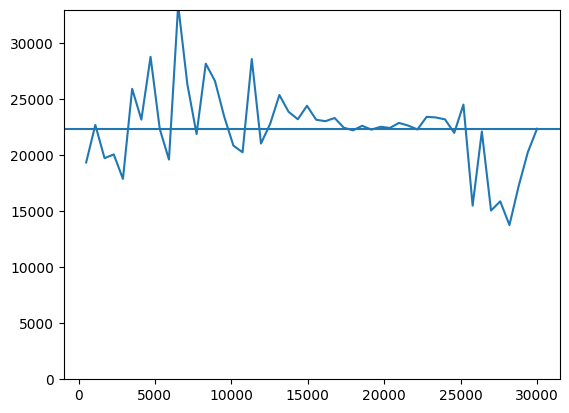

In [9]:
# Without bandwidth
endpoint_true = logXf_formula_gaussian(theta_true) * (-nlive)
iterations = np.linspace(500, 30000, 50)
endpoints = np.zeros_like(iterations)
for i, ndead in enumerate(iterations):
    ndead = int(ndead)
    points = points_at_iteration(samples, ndead)
    nk = np.array(points.nlive)
    logL = np.array(points.logL)
    X_mean = X_mu(nk)
    theta_l = analytic_lm_params(logL[ndead:], X_mean[ndead:], 1)
    endpoints[i] = logXf_formula_gaussian(theta_l) * (-nlive)
plt.plot(iterations, endpoints)
plt.axhline(y=endpoint_true)
plt.ylim(0, 33000)

##### With bandwidth

In [14]:
# Single iteration
nlive = 500
ndead = 10000
points = points_at_iteration(samples, ndead)
nk = np.array(points.nlive)
logL = np.array(points.logL)
X_mean = X_mu(nk)
theta_l = analytic_lm_params(logL[ndead:], X_mean[ndead:], 10)
alphas = np.linspace(0, 1, 5)
theta_best = minimise_bandwidth(logL, X_mean, ndead, alphas, 10)

In [29]:
%%capture
# Estimates of endpoint
endpoint_true = logXf_formula_gaussian(theta_true) * (-nlive)
iterations = np.linspace(500, 30000, 50)
endpoints = np.zeros_like(iterations)
alphas = np.linspace(0, 0.95, 5)
for i, ndead in enumerate(iterations):
    ndead = int(ndead)
    points = points_at_iteration(samples, ndead)
    nk = np.array(points.nlive)
    logL = np.array(points.logL)
    X_mean = X_mu(nk)
    theta_l = minimise_bandwidth(logL, X_mean, ndead, alphas, 10);
    endpoints[i] = logXf_formula_gaussian(theta_l) * (-nlive)
    # if (i % 5) == 0:
    #     print(i)
    # print(i)

(0.0, 40000.0)

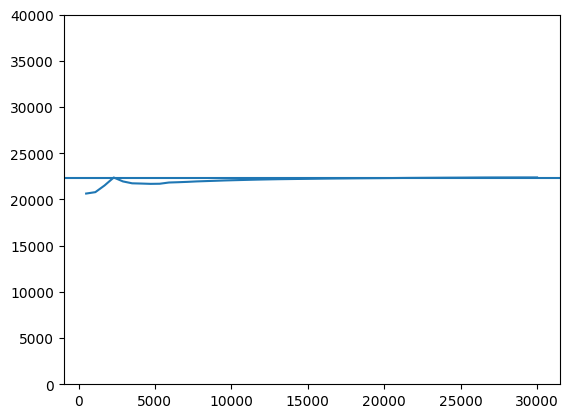

In [30]:
plt.plot(iterations, endpoints)
plt.axhline(y=endpoint_true)
plt.ylim(0, 40000)